# Divvy Re-Rebalancing Route Optimization Model

#### Author: Xuan Amy Lin 
#### xxlin@uchicago.edu | M.S. in Analytics, University of Chicago | linkedin.com/in/xuanamylin/

<br>

The project aims to solve the classical traffic re-balancing problem in bike sharing systems. The dataset used is open-sourced by Divvy, the bike sharing program in Chicago.

In this file, I will first introduce constant, variables used, present the objective function and constraints, and then solve for the optimal solution in Julia. The solver used is Gurobi commercial solver.

### Variables

$x_{i,j}$: A binary routing variable that indicates whether the van passes through station $i$ to $j$. For example, when $x_{1,3} = 1$, the van goes from station 1 to 3. If $x_{4,2}=0$, then the van does not travel from station 4 to 2.

$u_i$: The number of bikes on the van before arriving at station $i$

$d_i$: The number of bikes dropped off at station $i$

$p_i$: The number of bikes picked up at station $i$


### Constants

$N_i$: The ideal number of bikes after re-distribution at station $i$

$b_i$: The existing number of bikes at station $i$

$R_i$: The capacity or number of bike slots at station $i$

$C$: Capacity of the van

$t_{i,j}$: The amount of time required to travel from station $i$ to station $j$

$T$: The maximum period of time allowed to complete the entire trip

$S_i$: The variable indicating whether there is bike surplus at station $i$. In other words, $S_i = 1$ when $N_i > b_i$, and $S_i = 0$ when $N_i \leq b_i$. This is a dummy variable that helps to calculate absolute values.

$n$: The number of stations

### Assumptions

1. There is only one van distributing bikes.

2. Each station is visited once at most.

3. The van cannot drop off or pick up more than the ideal quantity at each station. For example, if N = 8 and b = 2, the van cannot drop off more than 6 bikes leaving N > 8.

4. The route starts from station 1 and ends at station 1. The van returns with zero bike.

5. The objective function is the sum of absolute values of errors. An error is defined as the difference between the ideal number of bikes (N) and the actual number of bikes after re-distribution (b + d - p).

### Objective Function

The objective function is **the number of dissatisfied customers**. 

A dissatisfied customer is defined as the customer who either finds no available bike to check out or finds no available rack to park the bike. In other words, having more than or less than the predicted number of bikes at a given station leads to a higher number of dissatisfied customers. 

With that said, the objective function is written as the absolute difference between predicted (expected) user demand and the actual user demand after optimization.

<br>

$$\min_{d_i, p_i} \quad \sum|N_i - (b_i + d_i - p_i)|$$

Now let's make it linear.

Since absolute values don't fulfill the requirement of linear programming, we rewrite the function into its equivalent below--a new function complemented by a constraint--with the help of the proxy variable S, the surplus variable.

$$\min_{d_i, p_i} \quad \sum_{i=1}^n S_i(b_i + d_i - p_i - N_i) + (1-S_i)(N_i - b_i - d_i + p_i)$$


s.t. $\quad$ For all station ($i$),  $S_i(b_i + d_i - p_i - N_i) + (1-S_i)(N_i - b_i - d_i + p_i) \geq 0)$

### Constaints

There are two clusters of constraints--routing constraints and capacity constraints. The routing constraints take care of the continuity of route while the capacity constraints is concerned with the number of bikes to be picked up or dropped off along that given route.

Some of the constaints are only applied to very specific scenarios, not to all scenarios, and it is achieved by the extensive of non-binding inequations. The intuitive explanations of these non-binding inequations are highlighted in blue.

##### Routing Constraints

<br>

* Same number of archs going in and going out

    For all stations $(i)$, $\quad \sum_{j=1}^n x_{i,j} = \sum_{j=1}^n x_{j,i}$

<br>

* All stations are passed once at most

    For all stations $(i)$, $\quad \sum_{j=1}^n x{i,j} \leq 1$

<br>

* Going from and to the same point is not permitted

    For all stations $(i)$, $\quad \sum_{i=1}^n x_{i,i} = 0$

<br>

* Going back and forth between 2 stations are not permitted; prevent situations where i to j and j to i are both travelled (2)

    For all pair of 2 stations ($i \neq j$), $\quad x_{i,j} + x_{j,i} \leq 1$

<br>

* Station 1 is the starting point and end point

    $\sum_{j=2}^n x_{1,j} = 1$

    $\sum_{i=2}^n x_{i,1} = 1$

<br>

* Traveled within the given time frame

    $\sum_{i=1}^n \sum_{j=1}^n x_{i,j}  t_{i,j} <= T$

<br>

* Ensure the continuity of route with a non-decreasing variable

    For all stations ($i$=1:n, $j$=2:n), $\quad nd_j \geq nd_i + 1 - 9999 (1-x_{i,j})$
    <br>
    <font color = blue>
    This is a non-biding inequation that basically means...
    <br>
    For routes traveled,  $\quad nd_j \geq nd_i + 1$.
    
    For routes not traveled, $\quad nd_j \geq nd_i - 9998$. Given that $nd_j \geq 0$, it's non-binding.
    </font>

##### Capacity Constraints

<br>

* The van starts empty and zero bike could be dropped off from an empty van

    $u_1 = 0$

    $d_1 = 0$

<br>

* Bikes picked up and dropped off fit into the given station

    For all stations $(i)$, $\quad 0 \leq p_i \leq b_i$

    For all stations $(i)$, $\quad 0 \leq d_i \leq R_i - b_i$

<br>

* Total pick-ups <= drop-offs

    $\sum_{i=1}^n d_i \leq \sum_{i=1}^n p_i$

<br>

* Either drop off or pick up at any given station

    For all stations ($i$=2:n), $\quad S_i d_i + (1-S_i)p_i = 0$

    <font color = blue>If station has surplus ($S_i = 1$), $\quad d_i = 0$.</font>

    <font color = blue>Otherwise ($S_i = 0$), $\quad p_i = 0$.</font>

<br>

* Synergy with the route: only drop off and pick up along the route

    For all stations ($i$=2:n), $\quad u_i+d_i + p_i + nd_i \leq 999\sum_{j=1}^n x_{j,i}$

    <font color = blue>If the van DOESN'T traverse station $i$, $u_i + d_i + p_i + nd_i \leq 0$.</font>

    <font color = blue>Otherwise, $\quad u_i + d_i + p_i + nd_i \leq 999$, non-binding.</font>

    For all stations ($i$=2:n), $\quad d_i + p_i \geq \sum_{j=1}^n x_{j,i}$

    <font color = blue>If the van DOES traverse station $i$, $\quad d_i + p_i \geq 1$.</font>

    <font color = blue>Otherwise, $\quad d_i + p_i \geq 0$, non-binding.</font>
        
<br>

* Continuity of van inventory $u_i$

    Between two stations (i=1:n, j=2:n), $\quad u_j \geq u_i - d_i + p_i - C(1-x_{i,j})$

    $\quad \quad \quad \quad \quad \quad \quad u_j \leq u_i - d_i + p_i - C(1-x_{i,j})$

    <font color = blue>If the van goes from $i$ to $j$, $u_j \geq u_i - d_i + p_i$.</font>

    <font color = blue>Otherwise, $u_j \geq u_i - d_i + p_i - C$, non-binding.</font>




### Julia Code Execution

In [10]:
using JuMP, Gurobi, CSV, DataFrames

##### Load Data

In [19]:
# Load Station Information
station_info = CSV.read("/Users/xuanlin/Desktop/OS/DivvyOptimization/rack_df_19.csv", copycols=true);

# Load Travel Time Matrix
time = CSV.read("/Users/xuanlin/Desktop/OS/DivvyOptimization/dist_matrix_19.csv", copycols=true);

# Demand Data (Predicted)
ds = CSV.read("/Users/xuanlin/Desktop/OS/DivvyOptimization/ds_weekday_19_adjusted.csv", copycols=true);
sort!(ds, :station_id, rev = false);

##### Set Up Constants

In [27]:
# Extract from loaded CSV
R = Array(station_info[!,:docks]);    # number of racks available at each station
t = time[:,1:end];                    # travel time from one station to another, a square matrix
b = Array(ds[:,9]);                   # actual number of bikes
N = Array(ds[:,10]);                  # expected number of bikes
id = Array(ds[:,1]);                  # save station id for later

# Mannually assign
K = 1;                       # number of truck(s) used to rebalance; assume to be 1
C = 20;                      # vehicle capacity
T = 60;                      # time constraint
n =28;                       # number of stations to optimize

# Dummy variable indicating surplus at station i
S = []
for i = 1:n
    if N[i] < b[i]
        append!(S, 1) # Need less bikes at stop
    else
        append!(S, 0) # Need more bikes at stop
    end
end

println("b: ", b);
println("N: ", N);
println("S: ", S);

b: [5, 12, 12, 4, 7, 5, 10, 12, 4, 7, 10, 8, 8, 9, 6, 6, 4, 5, 6, 7, 6, 7, 9, 9, 10, 9, 6, 8]
N: [6.0, 8.0, 5.0, 10.0, 9.0, 6.0, 8.0, 13.0, 8.0, 14.0, 7.0, 4.0, 9.0, 5.0, 3.0, 4.0, 6.0, 13.0, 8.0, 4.0, 9.0, 3.0, 7.0, 6.0, 6.0, 8.0, 9.0, 6.0]
S: Any[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]


##### Optimization Model

In [42]:
model = Model(with_optimizer(Gurobi.Optimizer, OutputFlag = 1));

@variable(model, x[i=1:n, j=1:n], Bin);
@variable(model, 0 <= u[i=1:n] <= C, Int);
@variable(model, p[i=1:n] >= 0, Int);
@variable(model, d[i=1:n] >= 0, Int);
@variable(model, nd[i=1:n] >= 0);

# --------------- Objective Function ---------------- #

# Objective function: minimize dissatisfied customers
@objective(model, Min, sum([(b[i] + d[i] - p[i] - N[i]) * S[i] + (N[i] - b[i] - d[i] + p[i]) * (1-S[i]) for i = 1:n]));

# make sure the van doesn't over drop-off or over pick-up
for i=1:n
   @constraint(model, (b[i] + d[i] - p[i] - N[i]) * S[i] + (N[i] - b[i] - d[i] + p[i]) * (1-S[i]) >= 0);
end


# --------------- Routing Constraints ---------------- #


for i=1:n
    
    # Same number of arcs going in and out
    @constraint(model, sum([x[i,j] for j=1:n]) == sum([x[j,i] for j=1:n]));
    
    # Go through each route once at most
    @constraint(model, sum([x[i,j] for j=1:n]) <= 1);
    
    # Going from and to the same station is illegal
    @constraint(model, x[i,i] == 0);
    
end


# No subtouring: going back and forth between two stations is illegal
for i=1:n
    for j=1:n
        if i != j
           @constraint(model, x[i,j] + x[j,i] <= 1);
        end
    end
end

# Set Station 1 as the starting point and the end point
@constraint(model, sum([x[1, j] for j=2:n]) == K);
@constraint(model, sum([x[j, 1] for j=2:n]) == K);

# Time constraint
@constraint(model, sum([x[i,j] * time[i,j] for i=1:n for j=1:n]) <= T);

# Avoid sub-tripping by implementing a non-decreasing variable "nd"
for i=1:n
    for j=2:n
        @constraint(model, nd[j] >= nd[i] + 1 - 9999 * (1-x[i,j]));
    end
end


# --------------- Capacity Constraints ---------------- #

@constraint(model, u[1] == 0);   # The van is empty at the start point
@constraint(model, d[1] == 0);   # Can't drop off from an empty van

# At each node...
for i=1:n
    
    # Pick up less bikes than available bikes at the given stop
    @constraint(model, 0 <= p[i] <= b[i]);

    # Drop off less bikes than available slots at the given stop
    @constraint(model, 0 <= d[i] <= R[i] - b[i]);
    
end

# Can't pick up more bikes than available in the system
# Total pickup >= dropoffs
@constraint(model, sum([d[i] for i=1:n]) <= sum([p[i] for i=1:n]));

# Either drop off or pick up at any given station
for i=2:n
    @constraint(model, d[i] * S[i] + p[i] * (1-S[i]) == 0);
end

# Synergy with the route
for i=2:n
    
    # If the van doesn't go through station i, d[i] = 0 and p[i] = 0
    # Otherwise, 
    @constraint(model, u[i] + d[i] + p[i] + nd[i] <= 2 * C * sum([x[j,i] for j=1:n]));

    # If the van go through station i, d[i] > 0 or d[i] > 0
    # Otherwise, non-binding
    @constraint(model, d[i] + p[i] >= sum([x[j,i] for j=1:n]));
    
end

# Continuity of van inventory u_i
for i=1:n
    for j=2:n
        @constraint(model, u[j] >= u[i] - d[i] + p[i] - C * (1-x[i,j]));
        @constraint(model, u[j] <= u[i] - d[i] + p[i] + C * (1-x[i,j]));
    end
end

#print(model);


Academic license - for non-commercial use only


##### Find the Optimal Solution

In [29]:
optimize!(model)
obj = JuMP.objective_value(model)
x = JuMP.value.(x);
d = JuMP.value.(d);
p = JuMP.value.(p);
u = JuMP.value.(u);
nd = JuMP.value.(nd);
println("Objective: ", obj)
println("X: ", x)
println("D: ", d)
println("P: ", p)
println("U: ", u)
println("Nd: ", nd)

Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 3279 rows, 952 columns and 16241 nonzeros
Model fingerprint: 0xb6df51bc
Variable types: 84 continuous, 868 integer (784 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [4e+00, 4e+01]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 88.0000000
Presolve removed 602 rows and 114 columns
Presolve time: 0.04s
Presolved: 2677 rows, 838 columns, 13265 nonzeros
Variable types: 27 continuous, 811 integer (760 binary)

Root relaxation: objective 1.000000e+00, 127 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    1.00000    0   32   88.00000    1.00000  98.9%     -    0s
H    0     0                      63.0000000    1.00000  98.4%     -    0s

In [41]:
obj_before = sum([(b[i] - N[i]) * S[i] + (N[i] - b[i]) * (1-S[i]) for i = 1:n])
time_used = sum([x[i,j] * time[i,j] for i=1:n for j=1:n])
println("Stations passed through: ", sum(x), " / ", n, " stations")
println("Time Used: ", sum(time_used))
println("Dissatisfied Customers (Before Optimization): ", obj_before)
println("Dissatisfied Customers (Best Case): ", abs(sum(b)-sum(N)))
println("Dissatisfied Customers (After Optimization): ", obj)

Stations passed through: 24.0 / 28 stations
Time Used: 58.08
Dissatisfied Customers (Before Optimization): 89.0
Dissatisfied Customers (Best Case): 7.0
Dissatisfied Customers (After Optimization): 10.0


It takes 58.08 minutes to travel the optimal route. Due to the 60-minute time constraint, 4 stations out of the total 29 stations are not traversed. One station is excluded because its predicted demand is the same as the actual demand. This results in the inability to meet the best case objective function.

##### The Optimal Route Plotted Against Chicago Map

<div>
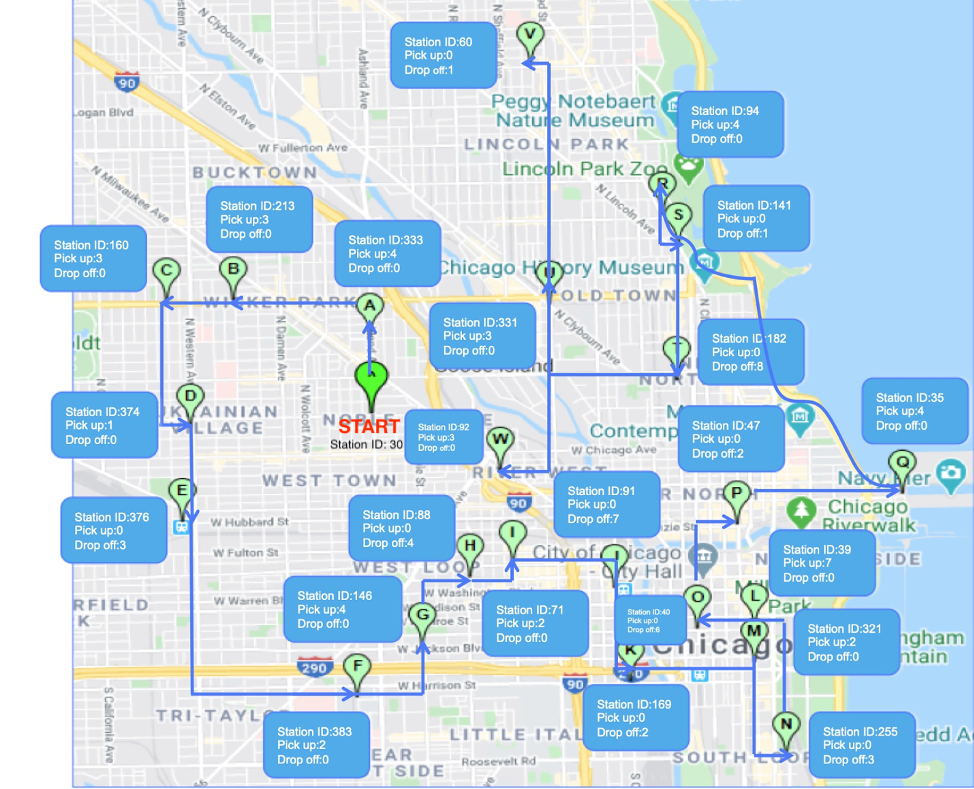
</div>

Image plotted by Grace Wei Yin

##### Detail data on the optimal route

|Station ID|Action|Van Inv. (Before Arrival)|Actual|Expected | After Optimization|Time to the Next Station (Minute)|
|---|---|---|---|---|---|---|
|30||0|5|6|5|1.43|
|333|pick up 4|0|10|6|6|2.95|
|213|pick up 3|4|7|4|4|1.801666667|
|160|pick up 3|7|6|3|3|2.681666667|
|374|pick up 1|10|9|8|8|2.145|
|376|drop off 3|11|6|9|9|5.725|
|383|pick up 2|8|8|6|6|1.9|
|146|pick up 4|10|9|5|5|2.375|
|88|drop off 4|14|4|8|8|0.893333333|
|71|pick up 2|10|10|8|8|1.945|
|91|drop off 7|12|7|14|14|1.853333333|
|169|drop off 2|5|4|6|6|3.218333333|
|39|pick up 7|3|12|5|5|1.675|
|321|pick up 2|10|9|7|7|0.956666667|
|255|drop off 3|12|6|9|9|3.483333333|
|40|drop off 6|9|4|10|10|2.536666667|
|47|drop off 2|3|7|9|9|3.005|
|35|pick up 4|1|12|8|8|6.948333333|
|94|pick up 4|5|8|4|4|0.625|
|141|drop off 1|9|8|9|9|2.325|
|182|drop off 8|8|5|13|13|2.55|
|331|pick up 3|0|9|6|6|0.315|
|60|drop off 1|3|5|6|6|3.976666667|
|92|pick up 3|2|10|7|7|2.365|
|Back to 30||5

##### Export Result into A CSV File

In [33]:
# Save Result
inventory = DataFrame(d = d, p = p, u = u, 
              nd = nd,N=N[1:n], b=b[1:n], R=R[1:n], time = time_used,
              after = b.+d.-p);
#names!(a, ["d", "p", "u"]);
route = DataFrame(x);
to_export = hcat(DataFrame(x = collect(1:1:n), station_id = ds[:,1]), route, inventory);
CSV.write("/Users/xuanlin/Desktop/OS/DivvyOptimization/weekday19_adjusted_60min.csv",
    to_export);